# Results

In [1]:
rm(list=ls())
options(warn = -1)

In [2]:
suppressMessages(library(fs))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))

In [3]:
folder <- getwd()

file_list <- dir_ls(file.path(folder, "predictions"), regexp = "\\.csv$")
df <- NULL

for (i in seq_along(file_list)) {
    file <- file_list[i]
    tmp <- read.csv(file, sep = ",")
    tmp <- tmp[, 1:2]
    colnames(tmp) <- c("date", paste0(strsplit(basename(file), "_")[[1]][1], "_pred"))
    if (is.null(df)) {
        df <- tmp  
        } else {
        df <- merge(df, tmp, by = "date", all = TRUE)  
      }
}

test <- read.csv(file.path(dirname(folder), "data/testing.csv"))
obs <- test[, 1:2]
colnames(obs) <- c("date", "obs")
df <- merge(df, obs, by = "date", all = TRUE)
df$date <- as.Date(df$date, format = "%Y-%m-%d")

In [4]:
sapply(strsplit(colnames(df[,2:7]), "_"), function(x) x[1])

[1] "GRU"          "LSTM"         "neurlprophet" "prophet"      "RNN"         
[6] "sarima"

In [5]:
metrics <- data.frame(matrix(NA, nrow = 6, ncol = 3))
colnames(metrics) <- c("MAPE", "RMSE", "MAE")
rownames(metrics) <- c(sapply(strsplit(colnames(df[,2:7]), "_"), function(x) x[1]))
                              
for (pred in colnames(df[, 2:7])){
    metrics[strsplit(pred, "_")[[1]][1], "MAPE"] <- mean(abs((df$obs - df[[pred]]) / df$obs), na.rm = TRUE) * 100
    metrics[strsplit(pred, "_")[[1]][1], "RMSE"] <- sqrt(mean((df$obs - df[[pred]])^2, na.rm = TRUE))
    metrics[strsplit(pred, "_")[[1]][1], "MAE"] <- mean(abs(df$obs - df[[pred]]), na.rm = TRUE) 
}
                              
metrics

,MAPE,RMSE,MAE
,<dbl>,<dbl>,<dbl>
GRU,15.63901,210.9892,161.5304
LSTM,16.79389,208.2456,166.3789
neurlprophet,24.48539,275.0198,214.3627
prophet,17.72782,218.5274,173.4519
RNN,22.30370,234.1144,191.4860
sarima,16.16559,232.9036,180.4565


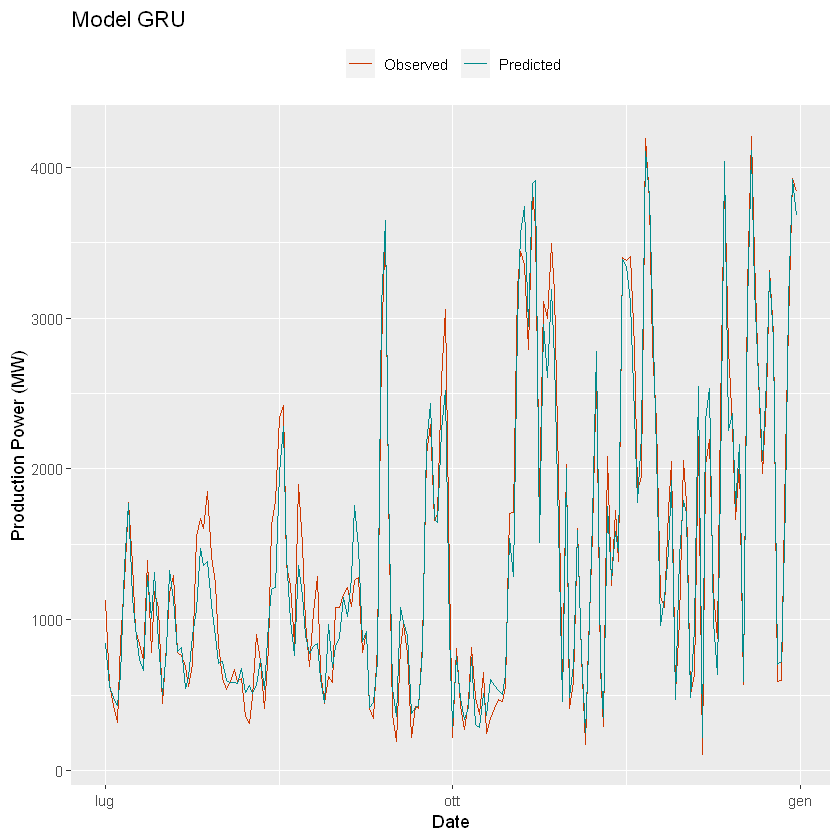

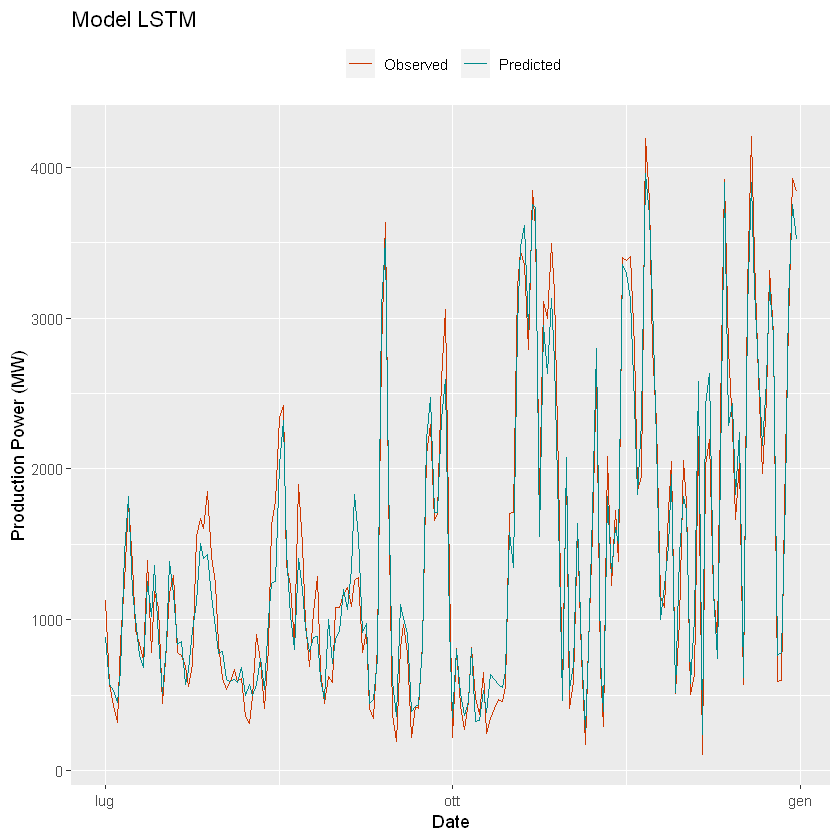

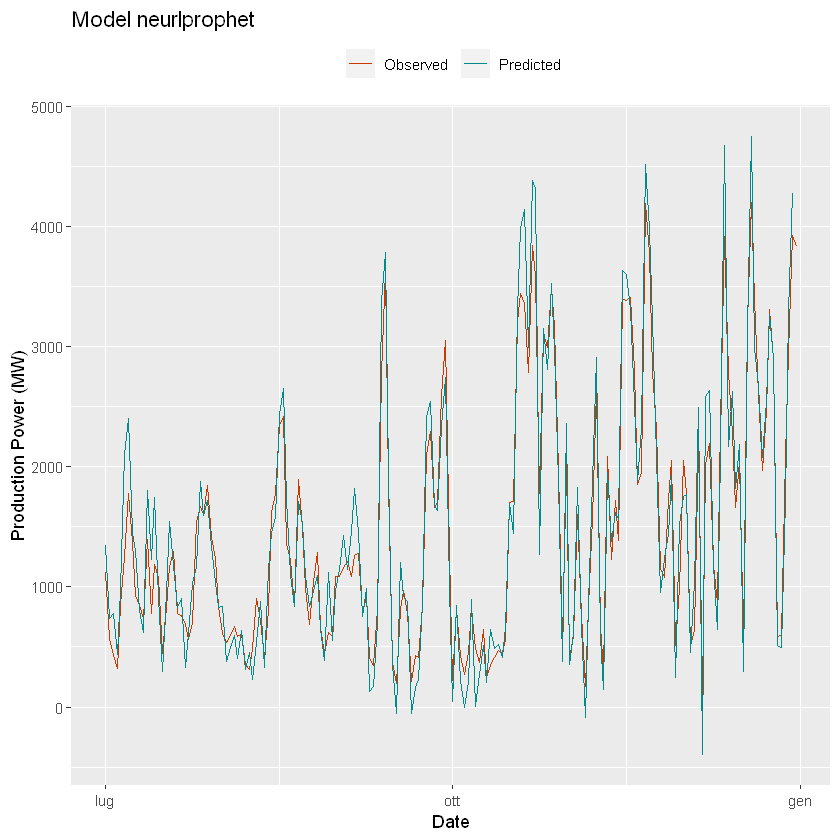

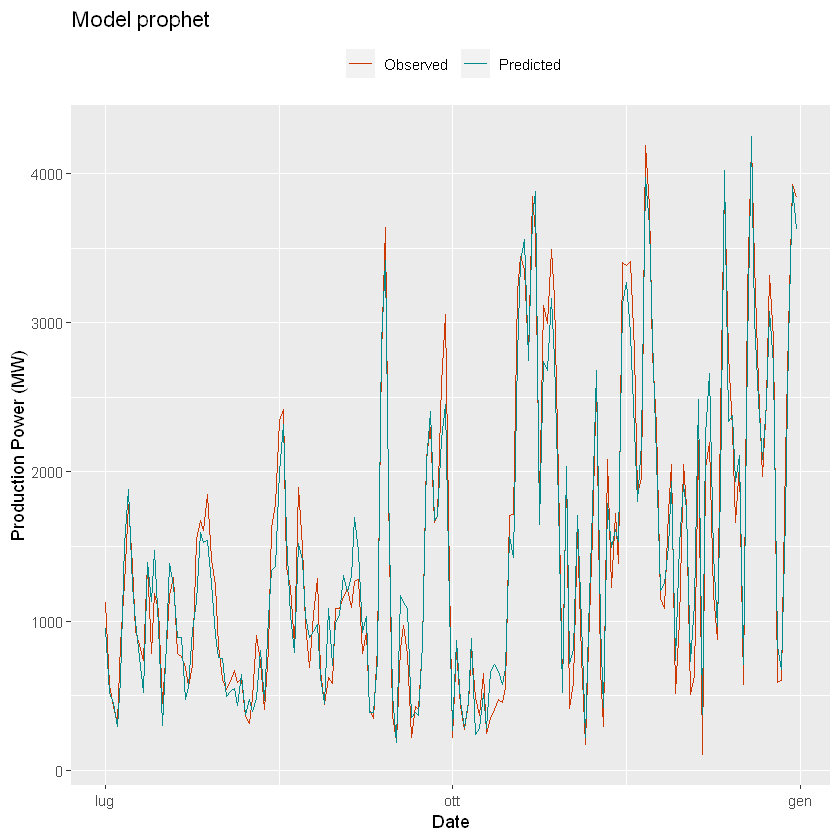

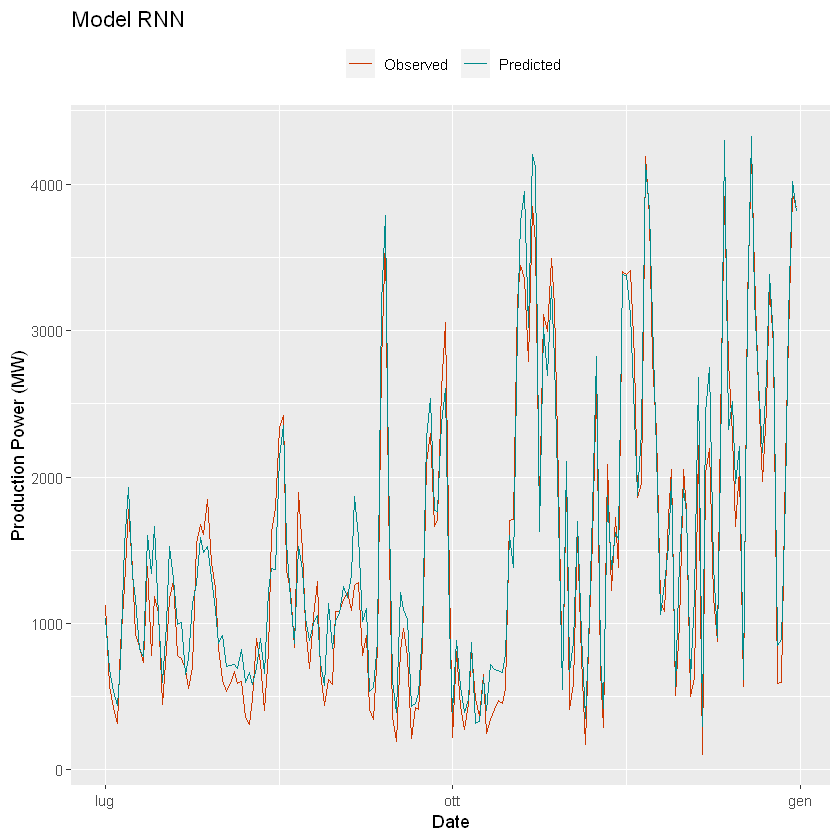

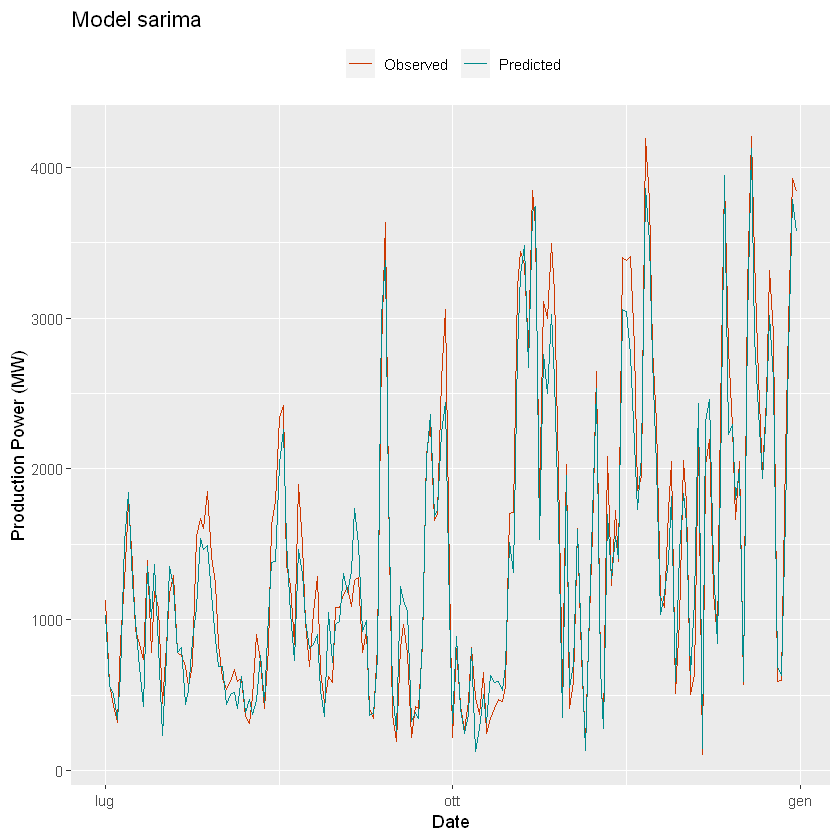

In [6]:
for (pred in colnames(df[, 2:7])){
    plt <- ggplot(df, aes(x=date))+
        geom_line(aes(x=date, y=obs, color="Observed")) +
        geom_line(aes(x=date, y=.data[[pred]], color="Predicted")) +
        labs(color="", x="Date", y="Production Power (MW)", title = paste0("Model ", strsplit(basename(pred), "_")[[1]][1]))+
        scale_colour_manual(values=c("Observed"="orangered3", "Predicted"="cyan4"))+
        theme(legend.position = "top")
    print(plt)    
}